In [1]:
using Pkg

Pkg.activate(".")

Pkg.add("StaticArrays")
Pkg.add("Setfield")
Pkg.add("ProgressMeter")
Pkg.add("Tables")

  Activating project at `~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_V`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_V/Project.toml`
  No Changes to `~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_V/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_V/Project.toml`
  No Changes to `~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_V/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_V/Project.toml`
  No Changes to `~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_V/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_V/Project.toml`
  No Changes to `~/Developer/Overdamped To Underdamped Langevin Limits/AB_

In [2]:
using LinearAlgebra, StaticArrays, Setfield
using Random, Distributions, Statistics
using ProgressMeter, Plots
using Tables, CSV, DataFrames
using BenchmarkTools

In [6]:
function forward_diff(X1, X2, p)
    # unpack variables from p 
    (; δ, Ω_inf, Ω_sup) = p

    # generate standard normal random vector
    # store as static arrays
    Z₁ = @SVector randn(3)
    Z₂ = @SVector randn(3)

    X1_next = X1 + δ * Z₁
    X2_next = X2 + δ * Z₂

    X1_next = mod.(X1_next, Ω_sup)
    X2_next = mod.(X2_next, Ω_sup)

    return (X1_next, X2_next)
end

# test
test_a = @SVector [8.0; 15.0; 11.0]
test_b = @SVector [1.0; 18.0; 9.0]
println(forward_diff(test_a, test_b, p))
# test
test_c = @SVector [ 8.0; 15.0; 45.0] # outside & drift too far
test_d = @SVector [-5.0; 23.0;  9.0] # outside & drift not far
println(forward_diff(test_c, test_d, p))

([7.721287808217475, 14.34057659307841, 11.601850168502756], [1.4988674726695925, 18.49595064657656, 8.773915797671531])
([8.45185265195708, 14.650896182083736, 4.7458445461200895], [14.274666918449803, 2.0638604495709885, 9.085373042404433])


In [82]:
@benchmark forward_diff($test_a, $test_b, $p)

BenchmarkTools.Trial: 10000 samples with 998 evaluations.
 Range (min … max):  21.585 ns … 40.791 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     24.466 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.493 ns ±  0.975 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                        ▂▅▇▃█▄▂                                
  ▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▂▄▅▅▇▆███████▅▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  21.6 ns         Histogram: frequency by time        28.4 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [83]:
@allocated forward_diff(test_a, test_b, p)

64

In [84]:
@code_warntype forward_diff(test_a, test_b, p)

MethodInstance for forward_diff(::SVector{3, Float64}, ::SVector{3, Float64}, ::@NamedTuple{Ω_inf::Float64, Ω_sup::Float64, T::Float64, Δt::Float64, C₀::Float64, λ::Float64, β::Float64, ε::Float64, γ::Float64, D::Float64, δ::Float64})
  from forward_diff(X1, X2, p) @ Main ~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_X/AB_C_X.ipynb:1
Arguments
  #self#::Core.Const(forward_diff)
  X1::SVector{3, Float64}
  X2::SVector{3, Float64}
  p::@NamedTuple{Ω_inf::Float64, Ω_sup::Float64, T::Float64, Δt::Float64, C₀::Float64, λ::Float64, β::Float64, ε::Float64, γ::Float64, D::Float64, δ::Float64}
Locals
  @_5::Int64
  #24::var"#24#26"{Float64, Float64}
  @_7::Int64
  #23::var"#23#25"{Float64, Float64}
  X2_next::SVector{3, Float64}
  X2_reflected::SVector{3, Float64}
  drift_not_far::Bool
  X2_next_inside::Base.Generator{SVector{3, Float64}, var"#24#26"{Float64, Float64}}
  X1_next::SVector{3, Float64}
  X1_reflected::SVector{3, Float64}
  X1_next_inside::Base.Generator{SVector{3, Flo

In [85]:
@benchmark forward_diff($test_c, $test_d, $p)

BenchmarkTools.Trial: 10000 samples with 994 evaluations.
 Range (min … max):  28.672 ns … 54.452 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     32.864 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.908 ns ±  1.199 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                            ▄▃█▃▂                              
  ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄██████▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  28.7 ns         Histogram: frequency by time        37.5 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [86]:
@allocated forward_diff(test_c, test_d, p)

64

In [87]:
@code_warntype forward_diff(test_c, test_d, p)

MethodInstance for forward_diff(::SVector{3, Float64}, ::SVector{3, Float64}, ::@NamedTuple{Ω_inf::Float64, Ω_sup::Float64, T::Float64, Δt::Float64, C₀::Float64, λ::Float64, β::Float64, ε::Float64, γ::Float64, D::Float64, δ::Float64})
  from forward_diff(X1, X2, p) @ Main ~/Developer/Overdamped To Underdamped Langevin Limits/AB_C_X/AB_C_X.ipynb:1
Arguments
  #self#::Core.Const(forward_diff)
  X1::SVector{3, Float64}
  X2::SVector{3, Float64}
  p::@NamedTuple{Ω_inf::Float64, Ω_sup::Float64, T::Float64, Δt::Float64, C₀::Float64, λ::Float64, β::Float64, ε::Float64, γ::Float64, D::Float64, δ::Float64}
Locals
  @_5::Int64
  #24::var"#24#26"{Float64, Float64}
  @_7::Int64
  #23::var"#23#25"{Float64, Float64}
  X2_next::SVector{3, Float64}
  X2_reflected::SVector{3, Float64}
  drift_not_far::Bool
  X2_next_inside::Base.Generator{SVector{3, Float64}, var"#24#26"{Float64, Float64}}
  X1_next::SVector{3, Float64}
  X1_reflected::SVector{3, Float64}
  X1_next_inside::Base.Generator{SVector{3, Flo

In [7]:
function backward_diff(X3, p)
    (; δ, Ω_inf, Ω_sup) = p
    Z = @SVector randn(3)
    X3_next = X3 + δ * Z
    X3_next = mod.(X3_next, Ω_sup)
    return (X3_next)
end

backward_diff (generic function with 1 method)

In [8]:
function backward_react(X3, p)
    (; ε, γ, Ω_inf, Ω_sup) = p

    # displacement of positions
    # sample uniform rv in B(0,ε)
    Z = @SVector randn(3)
    U = rand()
    η = ε * cbrt(U) * (Z / norm(Z))

    # original equation
    # γ * X1 + (1-γ) * X2 = X3
    # X1 - X2 = η
    X1 = X3 + (1 - γ) * η
    X2 = X3 - γ * η

    X1 = mod.(X1, Ω_sup)
    X2 = mod.(X2, Ω_sup)

    return (X1, X2)
end

# test
test_a = @SVector [10.0; 10.0; 10.0] # inside
println(backward_react(test_a, p))
test_b = @SVector [10.0; 15.0; 25.0] # outside
println(backward_react(test_b, p))
test_c = @SVector [10.0; -5.0; 25.0] # outside
println(backward_react(test_c, p))

([10.46834974158135, 11.343560981771523, 10.686285489225062], [9.53165025841865, 8.656439018228477, 9.313714510774938])
([10.571757330616292, 15.538936343126165, 7.703943579302887], [9.428242669383708, 14.461063656873835, 2.296056420697113])
([9.237890877649473, 14.709570443078528, 0.8375174921317132], [10.762109122350527, 15.290429556921472, 9.162482507868287])


In [92]:
@benchmark backward_react($test_a, $p)

BenchmarkTools.Trial: 10000 samples with 996 evaluations.
 Range (min … max):  22.173 ns … 79.485 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     25.394 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   25.604 ns ±  1.857 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▁▃▃▃   ▁▂▂▃▃▄▅▇██▇▇▅▂▁              ▁▁                   ▂
  ████████▅▇████████████████▇██▇█▇▇▇▇▇████████▅▇▆▇▇█▇▆▇▆▆▆▇▆▆ █
  22.2 ns      Histogram: log(frequency) by time        32 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [9]:
mutable struct Particle
    X::SVector{DIM,Float64}
end

mutable struct ReactState
    dir::Bool
    A::Particle
    B::Particle
    C::Particle
end

In [10]:
# Calculate the periodic distance between two positions
function period_dist(X1, X2, p)
    (; Ω_sup) = p
    diff1 = abs.(X1 - X2)
    diff2 = Ω_sup .- diff1
    return norm(min.(diff1, diff2))
end

period_dist (generic function with 1 method)

In [11]:
function update_state(state, p)
    (; λ₁, λ₀, Δt, ε) = p

    # Forward reaction-diffusion 
    if state.dir
        # forward diffusion
        X1, X2 = forward_diff(state.A.X, state.B.X, p)

        if (rand() <= λ₁ * Δt) && (period_dist(X1, X2, p) <= ε)
            # forward reaction
            X3 = 0.5 * (X1 + X2)

            state.C.X = X3
            state.dir = false
        else
            state.A.X = X1
            state.B.X = X2
        end

    # Backward reaction-diffusion
    else
        # backward diffusion
        X3 = backward_diff(state.C.X, p)

        if (rand() <= λ₀ * Δt)
            # backward reaction
            X1, X2 = backward_react(X3, p)

            state.A.X = X1
            state.B.X = X2
            state.dir = true
        else
            state.C.X = X3
        end
    end
end

# test
test_A = Particle(@SVector [15.0;  5.0;  9.0])
test_B = Particle(@SVector [15.0;  5.0;  9.0])
test_C = Particle(@SVector [10.0; 18.0; 11.0])
# rand(Binomial(1, 0.5))
test_state = ReactState(1, test_A, test_B, test_C)

update_state(test_state, p)
println(test_state.A)
println(test_state.B)
println(test_state.C)

Particle([14.818963114285003, 5.1285466361838115, 9.088466150552366])
Particle([15.02661928476089, 4.658857761969115, 8.545628730318214])
Particle([10.0, 18.0, 11.0])


In [101]:
test_state = ReactState(1, test_A, test_B, test_C)
@benchmark update_state($test_state, $p)

BenchmarkTools.Trial: 10000 samples with 998 evaluations.
 Range (min … max):  13.569 ns … 49.139 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     29.664 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.457 ns ±  7.573 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▁▆█▇▂                                   ▁▄▅▆▅▃           
  ▂▂▃▄██████▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▆██████▇▆▄▃▃▃▂▂▂ ▄
  13.6 ns         Histogram: frequency by time        35.4 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [102]:
test_state = ReactState(0, test_A, test_B, test_C)
@benchmark update_state($test_state, $p)

BenchmarkTools.Trial: 10000 samples with 999 evaluations.
 Range (min … max):  13.471 ns … 58.433 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.475 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.700 ns ±  6.410 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▄██▅                                                    
  ▂▂▂▃▆█████▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▃▃▄▅▅▅▄▄▃▂▂▂▂▂▂▂ ▃
  13.5 ns         Histogram: frequency by time        35.4 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [12]:
function count_C(react_states, num_states)
    num_AB = 0
    for i in 1:num_states
        num_AB += react_states[i].dir
    end
    num_C = num_states - num_AB
    return num_C
end

# test
test_states = []
random_dir = Bool.(rand(Binomial(1, 0.5), 5))
println(5- sum(random_dir))

test_v = @SVector [1.0; 1.0; 1.0]
test_p = Particle(@SVector [1.0; 1.0; 1.0])
ReactState(1, test_p, test_p, test_p)

for i in 1:5
    test_state = ReactState(random_dir[i], test_p, test_p, test_p)
    push!(test_states, test_state)
end
count_C(test_states, length(test_states))

2


2

In [13]:
function init_states(num_states, p)
    (; Ω_sup) = p
    react_states = []
    for _ in 1:num_states
        init_dir = 0

        # Initialize positions
        init_X1 = Ω_sup * (@SVector rand(3))
        init_X2 = Ω_sup * (@SVector rand(3))
        init_X3 = Ω_sup * (@SVector rand(3))

        # Initialize particles
        init_A = Particle(init_X1)
        init_B = Particle(init_X2)
        init_C = Particle(init_X3)

        init_state = ReactState(init_dir, init_A, init_B, init_C)
        push!(react_states, init_state)
    end
    return react_states
end

init_states (generic function with 1 method)

In [106]:
@benchmark init_states($1, $p)

BenchmarkTools.Trial: 10000 samples with 991 evaluations.
 Range (min … max):  40.070 ns …   3.648 μs  ┊ GC (min … max):  0.00% … 0.00%
 Time  (median):     46.292 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   63.059 ns ± 194.203 ns  ┊ GC (mean ± σ):  22.81% ± 7.40%

   ▁▂▁▁▅▇███▇▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁  ▁                         ▃
  ▆███████████████████████████████████████▇▇▇▇▇▆▆▇▆▆▅▅▅▄▅▅▄▅▃▄ █
  40.1 ns       Histogram: log(frequency) by time      77.9 ns <

 Memory estimate: 272 bytes, allocs estimate: 6.

In [15]:
# Parameters
const DIM = 3          # dim of the domain

p = (;
    Ω_inf = 0.0,       # nm
    Ω_sup = 20.0,      # nm
    T     = 0.5,       # s 
    Δt    = 1.0e-8,    # s 1.0e-8
    C₀    = 1.25e-4,   # nm^{-3}

    λ₁ = 40.5745,       # 1/s, varies based on Ω
    λ₀ = 17.3,          # 1/s
    ε  = 10.0,          # nm
    γ  = 0.5,           # ratio
    D  = 1.0e6,         # nm
)
p = (; p..., δ=sqrt(2 * p.D * p.Δt))

(Ω_inf = 0.0, Ω_sup = 20.0, T = 0.5, Δt = 1.0e-8, C₀ = 0.000125, λ₁ = 40.5745, λ₀ = 17.3, ε = 10.0, γ = 0.5, D = 1.0e6, δ = 0.1414213562373095)

In [16]:
#function test_fun(p)
    (; T, Δt) = p
    num_time_steps = Int(floor(T / Δt))
    num_sim = 1100

    @showprogress for n in 1:num_sim
        num_C[1] = 1
        for i in 1:num_time_steps
            num_C[i+1] = i
        end
        C_matrix[:, n] = num_C
    end
#end

UndefVarError: UndefVarError: `num_C` not defined

In [17]:
"""
    Main
"""

# Initialize
(; C₀, Ω_sup, T, Δt) = p

num_sim = 1100
num_Δt = Int(floor(T / Δt))
num_states = Int(C₀ * (Ω_sup)^3)

num_saveΔt = div(num_Δt + 1, 1000) + 1
C_matrix = Matrix{Float64}(undef, num_saveΔt, num_sim)
num_C_vec = zeros(Float64, num_saveΔt)
num_C_vec[1] = num_states

# Main
@showprogress for n in 1:num_sim
    react_states = init_states(num_states, p)
    for i in 1:num_Δt
        for j in 1:num_states
            update_state(react_states[j], p)
        end
        if mod(i + 1, 1000) == 0
            num_C_vec[div(i + 1, 1000)+1] = count_C(react_states, num_states)
        end
    end
    C_matrix[:, n] = num_C_vec
end

Progress: 100%|█████████████████████████████████████████| Time: 2:33:47


In [18]:
C_means = [mean(row) for row in eachrow(C_matrix)]
C_stds = [std(row) for row in eachrow(C_matrix)]

# Store
C_df = DataFrame(mean=C_means, std=C_stds)
file_path = "ABCX_period_sim1100_Δt1e-8.csv"
CSV.write(file_path, C_df)

"ABCX_period_sim1100_Δt1e-8.csv"

In [20]:
ABCX_rej_path = "ABCX_sim11000.csv"
ABCX_rej_df = CSV.read(ABCX_rej_path, DataFrame)

ABCX_per_path = "ABCX_period_sim1100_Δt1e-8.csv"
ABCX_per_df = CSV.read(ABCX_per_path, DataFrame)

ABCV_beta10_path = "ABCV_sim11000_beta1.0e10.csv"
ABCV_df_beta10 = CSV.read(ABCV_beta10_path, DataFrame)

println(ABCX_rej_df[1:10, :])

10×2 DataFrame
 Row │ mean      std        
     │ Float64   Float64    
─────┼──────────────────────
   1 │ 1.0       0.0
   2 │ 1.0       0.0
   3 │ 1.0       0.0
   4 │ 0.999909  0.00953463
   5 │ 0.999818  0.0134834
   6 │ 0.999636  0.0190667
   7 │ 0.999545  0.0213162
   8 │ 0.999545  0.0213162
   9 │ 0.999545  0.0213162
  10 │ 0.999364  0.0252194


In [26]:
length(ABCX_rej_df.mean)

50001

In [27]:
length(t_steps)

500001

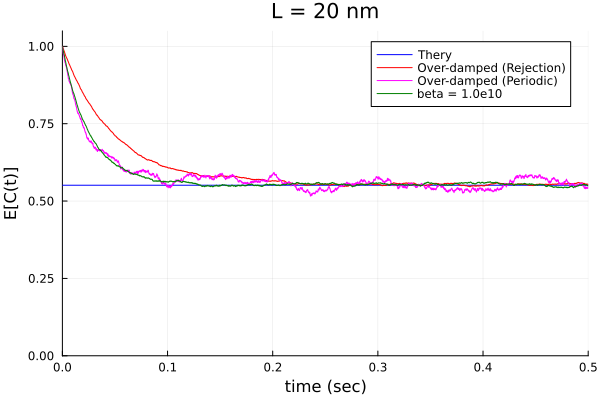

In [30]:
indices = 1:1000:(num_time_steps+1)
time_steps = p.Δt * collect(0:num_time_steps)
t_steps = time_steps[indices]

ref_line = fill(0.5512, length(t_steps))
plot(t_steps, ref_line,
    label="Thery",
    xlabel="time (sec)",
    ylabel="E[C(t)]",
    title="L = 20 nm",
    color="blue")

plot!(t_steps, ABCX_rej_df.mean,
    label="Over-damped (Rejection)",
    color="red")

plot!(t_steps, ABCX_per_df.mean,
    label="Over-damped (Periodic)",
    color="magenta")

plot!(t_steps, ABCV_df_beta10.mean,
    label="beta = 1.0e10",
    color="green")

ylims!(0, 1.05)
xlims!(0.0, p.Δt * num_time_steps)
display(plot!())

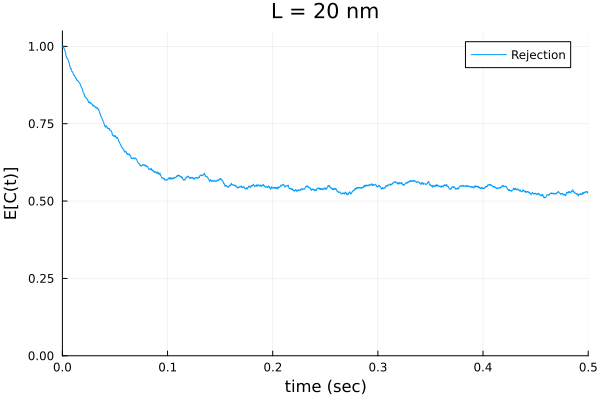

In [57]:
time_steps = p.Δt * collect(0:num_time_steps)
indices = 1:1000:(num_time_steps+1)
sub_t = time_steps[indices]
sub_y = C_means[indices]
#sub_t = time_steps
#sub_y = C_means

plot(sub_t, sub_y,
     xlabel="time (sec)",
     ylabel="E[C(t)]",
     label="Rejection",
     title="L = 20 nm")
ylims!(0, 1.05)
xlims!(0.0, p.Δt * num_time_steps)

# Display the plot
display(plot!())  # or plot!(); for Jupyter notebooks

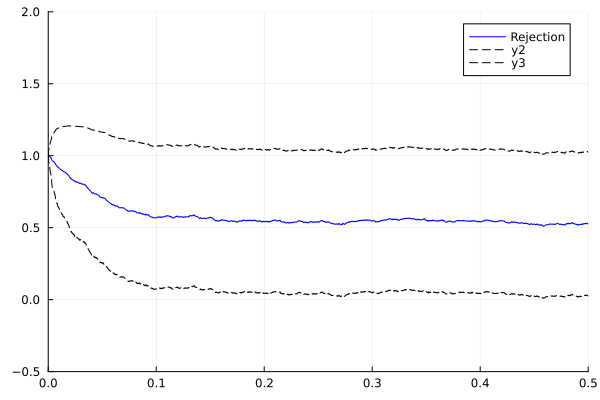

In [58]:
indices = 1:1000:(num_time_steps+1)
time_steps = p.Δt * collect(0:num_time_steps)

t_steps = time_steps[indices]
mean_values = C_means[indices]
upper_bound = mean_values .+ C_stds[indices]
lower_bound = mean_values .- C_stds[indices]

plot(t_steps, mean_values, label="Rejection", color=:blue)
plot!(t_steps, upper_bound, color=:black, linestyle=:dash)
plot!(t_steps, lower_bound, color=:black, linestyle=:dash)

# Fill the region between the upper and lower bounds
# plot!(time, upper_bound, fillrange=lower_bound, fillalpha=0.3, color=:gray)

ylims!(-0.5, 2.0)
xlims!(0.0, p.Δt * num_time_steps)

plot!()

In [72]:
div(35, 6)

5

In [73]:
div(2000, 1000)

2